A script for testing the different parameters of dropout when training U-Net. 


In [ ]:
!pip install keras-unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import sys
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet
from keras.callbacks import ModelCheckpoint
from keras_unet.metrics import iou, iou_thresholded
from keras.optimizers import Adam, SGD
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_segm_history
from sklearn.preprocessing import label_binarize
import time
from sklearn.metrics import roc_curve, auc, roc_auc_score
import csv
import time
from matplotlib.pyplot import cm
from cycler import cycler

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
train_images = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingImages/*.tif"))
train_masks = sorted(glob.glob("/content/drive/My Drive/UNet/TrainingLabels/*.tif"))

test_images = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestImages/*.tif"))
test_masks = sorted(glob.glob("/content/drive/My Drive/UNet/IndependentTestLabels/*.tif"))

In [ ]:
def prepare_images_masks(images, masks):
    
    I_list = []
    M_list = []
    for image, mask in zip(images, masks):
        I = Image.open(image)
        M = Image.open(mask)

        I = np.array(I)
        M = np.array(M)

        I_list.append(I/(I.max()))
        M_list.append(M/(M.max()))

    X = np.asarray(I_list, dtype=np.float32)
    Y = np.asarray(M_list, dtype=np.float32)

    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 
    Y = Y.reshape(Y.shape[0], Y.shape[1], Y.shape[2], 1)
    
    return X, Y


X, Y = prepare_images_masks(train_images, train_masks)
X_test, Y_test = prepare_images_masks(test_images, test_masks)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.75, random_state=33)

print("# X_train: %d" % X_train.shape[0])
print("# Y_train: %d" % Y_train.shape[0])
print("# X_val: %d" % X_val.shape[0])
print("# Y_val: %d" % Y_val.shape[0])

# X_train: 8
# Y_train: 8


In [ ]:
train_gen = get_augmented(
    X_train, Y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=360.0,
        fill_mode='constant')
)

In [ ]:
# Parameters
layers = [4]
filters = [12]
dropouts = [0.,0.1,0.2,0.3,0.4,0.5]
dropoutPerLayer = [0,0.05,0.1]
dropoutUpsampling = [False, True]

Utdata för streaming har trunkerats till de sista 5000 raderna.
10/10 [==============================] - 1s 120ms/step - loss: 0.2105 - binary_accuracy: 0.8979
Epoch 108/200
10/10 [==============================] - 1s 122ms/step - loss: 0.1972 - binary_accuracy: 0.9098
Epoch 109/200
10/10 [==============================] - 1s 121ms/step - loss: 0.1855 - binary_accuracy: 0.9101
Epoch 110/200
10/10 [==============================] - 1s 127ms/step - loss: 0.2071 - binary_accuracy: 0.9021
Epoch 111/200
10/10 [==============================] - 1s 120ms/step - loss: 0.1945 - binary_accuracy: 0.9078
Epoch 112/200
10/10 [==============================] - 1s 124ms/step - loss: 0.2230 - binary_accuracy: 0.8930
Epoch 113/200
10/10 [==============================] - 1s 120ms/step - loss: 0.1973 - binary_accuracy: 0.9049
Epoch 114/200
10/10 [==============================] - 1s 125ms/step - loss: 0.1955 - binary_accuracy: 0.9056
Epoch 115/200
10/10 [==============================] - 1s 122ms/step -

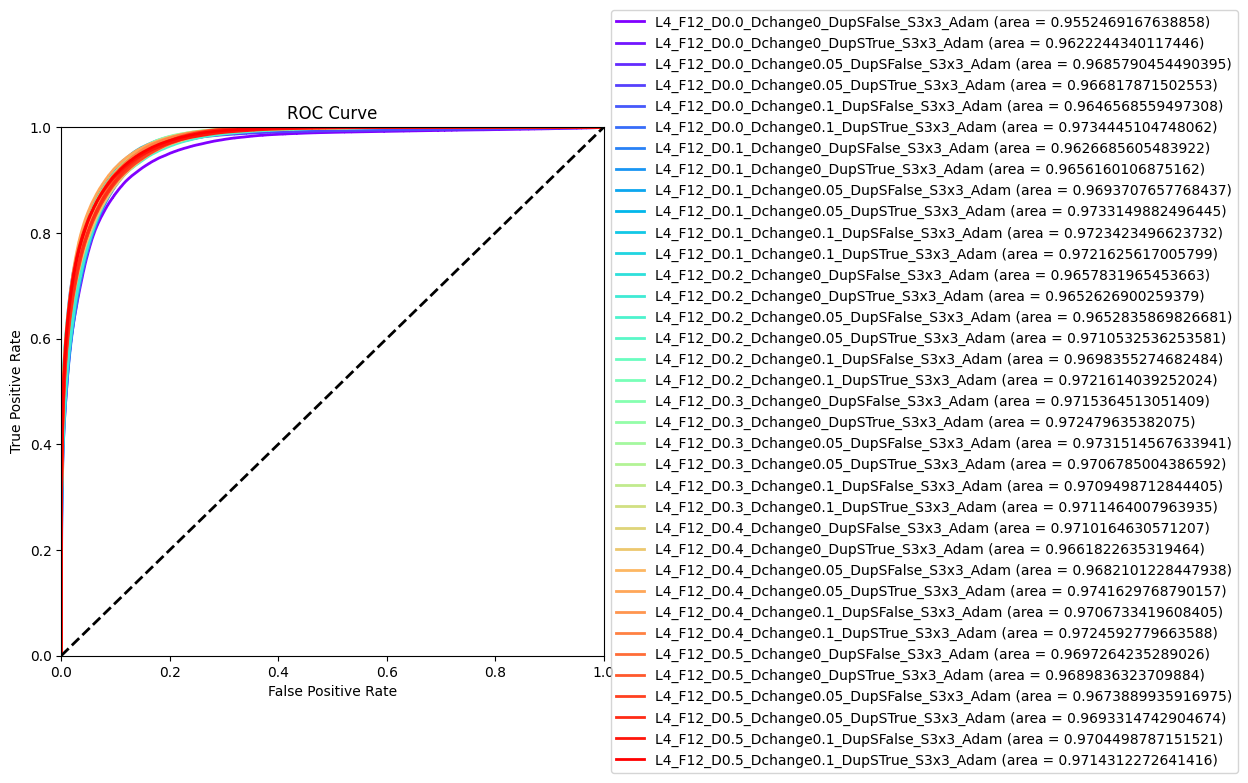

In [ ]:
# For testing different levels of dropout

input_shape = X_train[0].shape
index = 0

# Initialize arrays for saving data: shape, time elapsed, auc, fpr, tpr
shapes = []
time_elapsed = []
auc_list = []
fpr_list = []
tpr_list = []

# For larger plot
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()
lw = 2

# Initialize color cycle
n_lines = len(layers)*len(filters)*len(dropouts)*len(dropoutPerLayer)*len(dropoutUpsampling)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.rc('axes', prop_cycle=(cycler('color', colors)))

for layer in layers:
  for filter in filters:
    for dropout in dropouts:
      for dropoutIncrease in dropoutPerLayer:
        for dropoutUpsamplingBool in dropoutUpsampling:
    
          # Define net architecture
          model = custom_unet(
            input_shape,
            filters=filter,
            num_layers=layer,
            dropout = dropout,
            dropout_change_per_layer = dropoutIncrease,
            use_dropout_on_upsampling = dropoutUpsamplingBool
          )

          # Define file name
          model_filename = f'UNet_L{layer}_F{filter}_D{dropout}_Dchange{dropoutIncrease}_DupS{dropoutUpsamplingBool}_S3x3_Adam.h5'
          

          my_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10),
            tf.keras.callbacks.ModelCheckpoint(filepath='model.' + model_filename,
                                              verbose=1, 
                                              monitor='val_loss', 
                                              save_best_only=True)
          ]

          model.compile(
            optimizer=Adam(), 
            #optimizer=SGD(lr=0.0001, momentum=0.9),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.BinaryAccuracy()]
          )

          start_time = time.time()
          
          history = model.fit(
            train_gen,
            steps_per_epoch=10,
            epochs=200,
            validation_data=(X_val, Y_val),
            callbacks=[my_callbacks]
          )

          end_time = time.time()
          elapsed_time = (end_time - start_time)/60

          # Saved your trained model to Google Drive in the same directory as all images for later use if needed
          # model.save(F"/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/{model_filename}")

          # Prediction
          Y_pred = model.predict(X_test)

          N_Y_pred = Y_pred.shape[0]
          Y_score = np.empty(())
          Y_true = np.array(())

          for i in range(N_Y_pred):
              I_score = Y_pred[i, :, :, :]
              I_score = I_score.flatten()
              
              I_true = Y_test[i, :, :, :]
              I_true = I_true.flatten()
              I_true_b = label_binarize(I_true, classes=[0, 1])
              
              if i == 0:
                  Y_score = I_score
                  Y_true = I_true_b
              else:
                  Y_score = np.concatenate((Y_score, I_score), axis = 0)
                  Y_true = np.concatenate((Y_true, I_true_b), axis = 0)
              
          # Calculate false and true positive rate as well as the AUC       
          fpr, tpr, _ = roc_curve(y_true=Y_true, y_score=Y_score)
          roc_auc = auc(fpr, tpr)

          # Add values

          shapes.append(f'L{layer}_F{filter}_D{dropout}_Dchange{dropoutIncrease}_DupS{dropoutUpsamplingBool}_S3x3_Adam')
          time_elapsed.append(elapsed_time)
          auc_list.append(roc_auc)
          fpr_list.append(fpr)
          tpr_list.append(tpr)

          # Plot performance
          plt.plot(fpr, tpr, lw=lw, label=f'L{layer}_F{filter}_D{dropout}_Dchange{dropoutIncrease}_DupS{dropoutUpsamplingBool}_S3x3_Adam (area = {roc_auc})')

          

timestr = time.strftime("%Y%m%d-%H%M%S")

with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/dropout_adam_{timestr}.csv', 'w', newline='') as myfile:
  wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
  for i in range(len(layers)*len(filters)*len(dropouts)*len(dropoutPerLayer)*len(dropoutUpsampling)):
    wr.writerow([shapes[i], time_elapsed[i],auc_list[i]])

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/dropout_{timestr}.png', bbox_inches='tight')
plt.show()


In this step we have a trained network. Below are ways to plot the training times and performances.

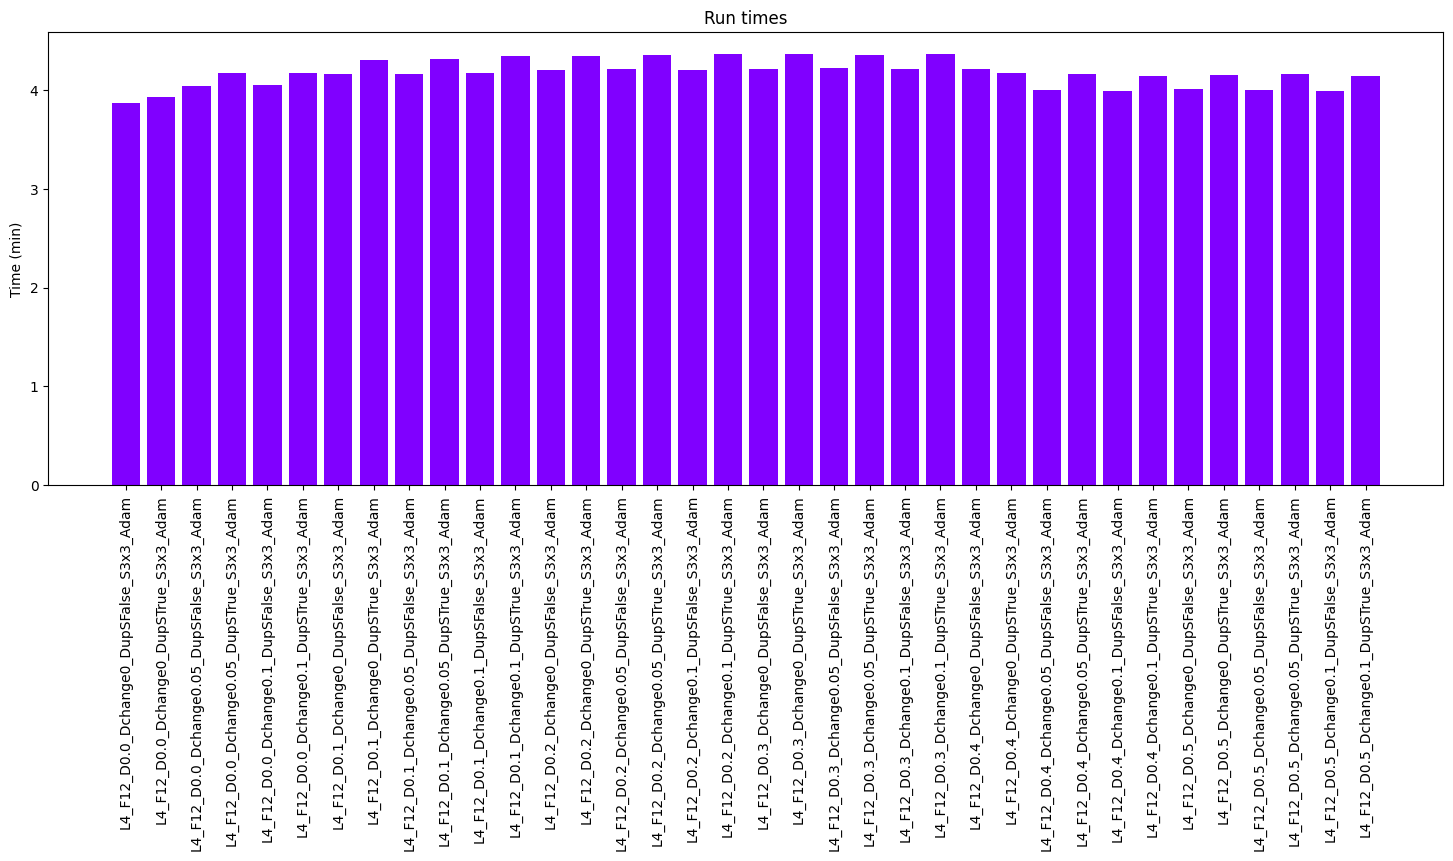

In [ ]:
from matplotlib.pyplot import cm
from cycler import cycler

# Print the time it took for reach run
with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/dropout_adam_{timestr}.csv', mode='r') as infile:
    reader = csv.reader(infile)
    #for rows in reader:
    D = {rows[0]:float(rows[1]) for rows in reader}


# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()

# Initialize color set
n_lines = len(layers)*len(filters)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.title('Run times')
plt.ylabel('Time (min)')
plt.xticks(rotation='vertical')
plt.show()

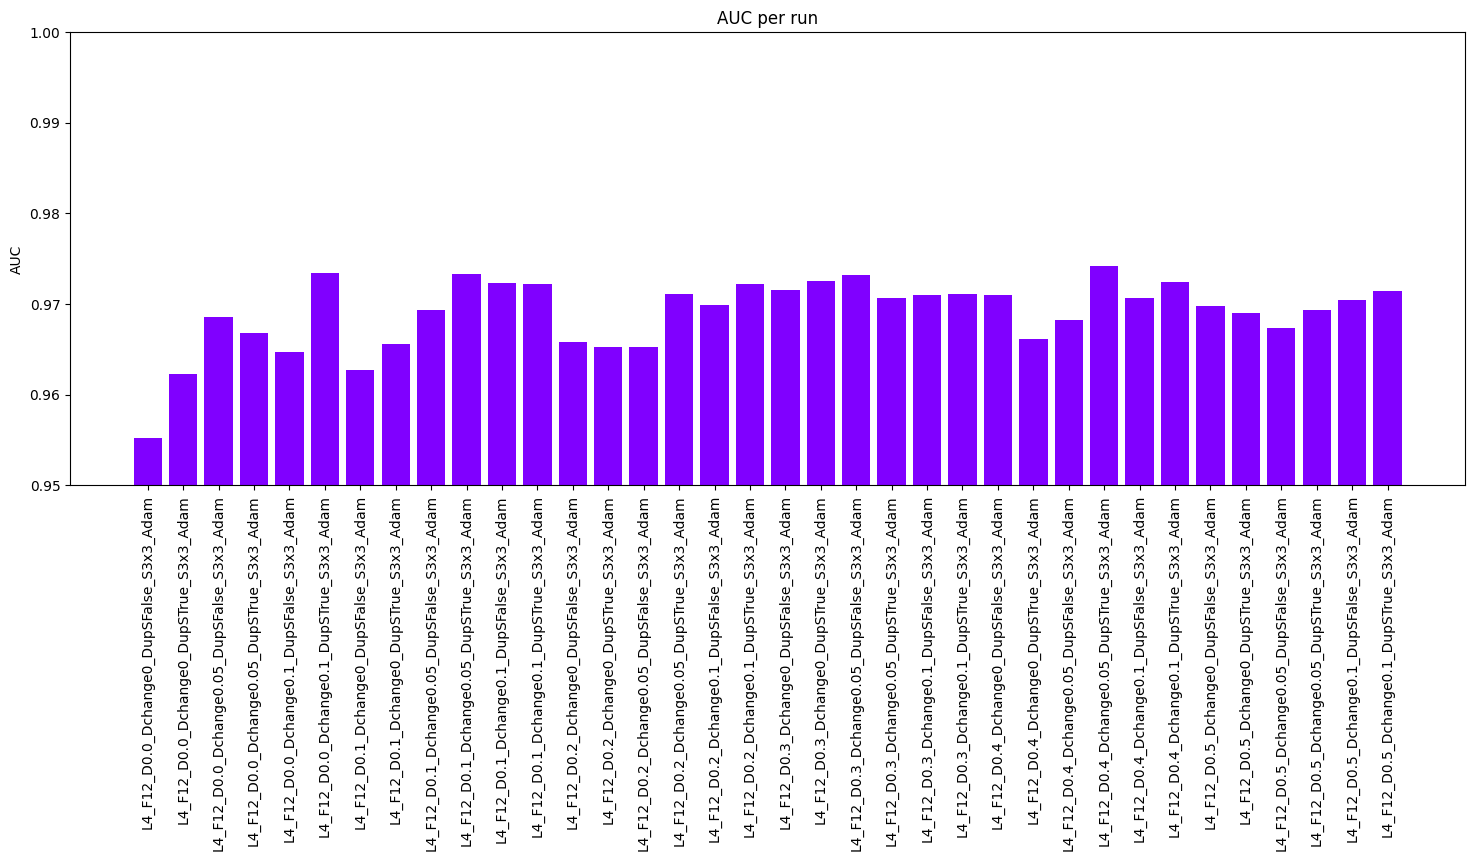

In [ ]:
from matplotlib.pyplot import cm
from cycler import cycler

# Print the AUC for reach run
with open(f'/content/drive/My Drive/Skola/Tillämpad Bioinformatik (slutkursen)/Unet-output/dropout_adam_{timestr}.csv', mode='r') as infile:
    reader = csv.reader(infile)
    #for rows in reader:
    D = {rows[0]:float(rows[2]) for rows in reader}


# For larger plot
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.figure()

# Initialize color set
n_lines = len(layers)*len(filters)
colors=cm.rainbow(np.linspace(0,1,n_lines))

plt.ylim([0.95, 1.0])
plt.bar(list(D.keys()), list(D.values()), color=colors)
plt.title('AUC per run')
plt.ylabel('AUC')
plt.xticks(rotation='vertical')
plt.show()